In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
matplotlib.rcParams.update({'font.size': 18})
import umap

INFO: Using pytorch backend
/tmp/ipykernel_1117668/2806268357.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [27]:
model_src = "lightning_logs/GT_Class/version_5"
model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    #"GTs/16Mnist_Class/checkpoints/last.ckpt"
    f"{model_src}/checkpoints/last.ckpt"
)
model.eval

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  10
[10, 32, 32, 10]
[10, 32, 32, 10]
[10, 32, 32, 10]
[10, 32, 32, 10]


<bound method Module.eval of FreeFormInjectiveFlow(
  (cross_entropy): CrossEntropyLoss()
  (models): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (model): Sequential(
        (encoder): Sequential(
          (0): Unflatten(dim=-1, unflattened_size=(1, 16, 16))
          (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (4): ReLU()
          (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (6): ReLU()
          (7): Flatten(start_dim=-3, end_dim=-1)
          (8): Linear(in_features=1024, out_features=10, bias=True)
        )
        (decoder): Sequential(
          (0): Linear(in_features=10, out_features=4096, bias=True)
          (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
          (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (3): ReLU()
          (4):

In [28]:
from fff.model.utils import guess_image_shape
class Truncate(torch.nn.Module):
            def __init__(self):
                super(Truncate, self).__init__()
                enc_conv = list(
                    list(
                    list(
                    list(
                        model.children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[0]
                enc_res = list(
                    list(
                    list(
                    list(
                    list(
                        model.children()
                    )[1].children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[:]
                print(enc_res)
                self.features = torch.nn.Sequential(
                    enc_conv, *enc_res
                )

            def cat_x_c(self, x, c):
                # Reshape as image, and concatenate conditioning as channel dimensions
                has_batch_dimension = len(x.shape) > 1
                if not has_batch_dimension:
                    x = x[None, :]
                    c = c[None, :]
                batch_size = x.shape[0]
                input_shape = guess_image_shape(model.data_dim)
                x_img = x.reshape(batch_size, *input_shape)
                c_img = c[:, :, None, None] * torch.ones(batch_size, model.cond_dim, *input_shape[1:], device=c.device)
                out = torch.cat([x_img, c_img], -3).reshape(batch_size, -1)
                if not has_batch_dimension:
                    out = out[0]
                return out
            
            def encode(self, x, c):
                x = self.features(self.cat_x_c(x,c))
                return x

Features = Truncate()

[SkipConnection(
  (inner): Sequential(
    (Hidden_Layer_0): Linear(in_features=10, out_features=32, bias=True)
    (Hidden_Activation_0): SiLU()
    (Dropout_1): Dropout1d(p=0.5, inplace=False)
    (Hidden_Layer_1): Linear(in_features=32, out_features=32, bias=True)
    (Hidden_Activation_1): SiLU()
    (Output_Layer): Linear(in_features=32, out_features=10, bias=True)
  )
), SkipConnection(
  (inner): Sequential(
    (Hidden_Layer_0): Linear(in_features=10, out_features=32, bias=True)
    (Hidden_Activation_0): SiLU()
    (Dropout_1): Dropout1d(p=0.5, inplace=False)
    (Hidden_Layer_1): Linear(in_features=32, out_features=32, bias=True)
    (Hidden_Activation_1): SiLU()
    (Output_Layer): Linear(in_features=32, out_features=10, bias=True)
  )
), Softmax(dim=None)]


In [25]:
torch.set_grad_enabled(False)

In [16]:
df = pd.read_pickle("data/Mnist_Class_ext")
# read targets and conditions from dataframe
train_data, train_targets = (
    torch.from_numpy(df["train_x"]),
    torch.from_numpy(df["train_y"]),
)

center = torch.mean(train_targets)
std = torch.std(train_targets)
print(train_targets[-100:-90])

tensor([[6.0260e-08, 2.2809e-10, 3.1849e-05, 3.1336e-08, 2.4322e-10, 2.4814e-05,
         1.1473e-09, 2.1957e-12, 9.9994e-01, 7.9078e-07],
        [2.6247e-06, 5.7917e-03, 3.4943e-05, 1.6193e-01, 1.7287e-11, 5.1784e-04,
         9.4880e-11, 1.0589e-03, 8.2795e-01, 2.7098e-03],
        [9.9985e-01, 1.5251e-18, 1.4437e-06, 9.5855e-08, 2.8000e-11, 1.3522e-04,
         1.3592e-09, 4.6198e-06, 8.1558e-06, 9.8624e-07],
        [2.6229e-10, 1.4811e-10, 3.7331e-12, 1.7909e-07, 1.2231e-10, 1.3516e-07,
         2.8284e-14, 3.4339e-01, 9.6529e-06, 6.5660e-01],
        [5.8818e-06, 6.1519e-13, 3.9501e-04, 9.5321e-10, 1.5514e-02, 3.1039e-05,
         4.7298e-04, 4.9684e-09, 3.2517e-02, 9.5106e-01],
        [1.3054e-10, 2.2082e-08, 3.7446e-11, 7.5145e-06, 5.6518e-03, 8.2253e-05,
         1.7193e-09, 4.3935e-04, 2.6901e-06, 9.9382e-01],
        [1.6288e-07, 6.0076e-07, 2.4628e-08, 1.6157e-07, 3.0692e-07, 2.0976e-04,
         1.3065e-09, 9.9972e-01, 3.2517e-06, 6.3693e-05],
        [9.9999e-01, 1.3058

encoding traindata...
encoding valdata...
encoding testdata...


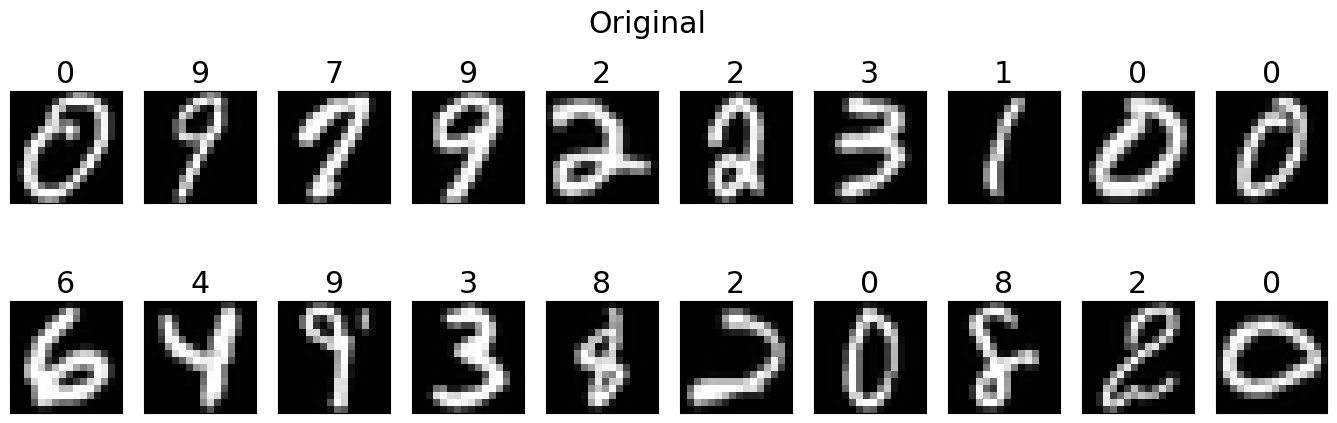

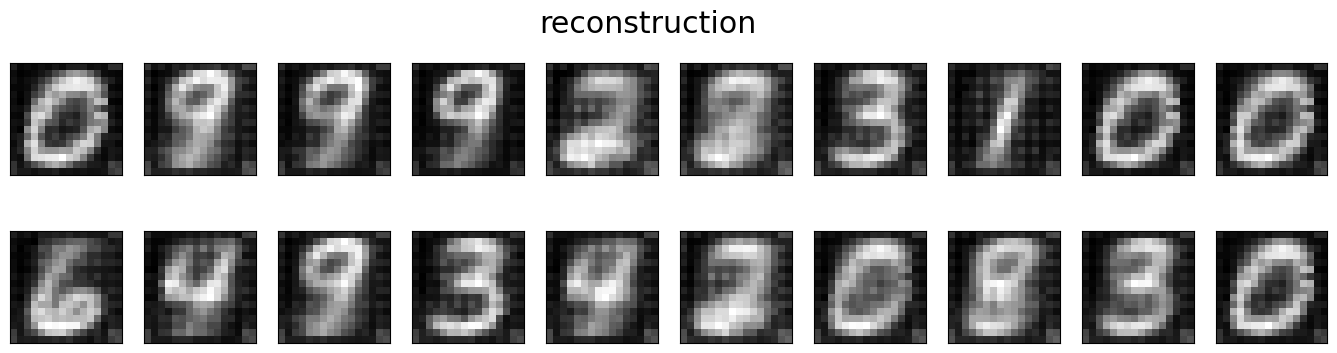

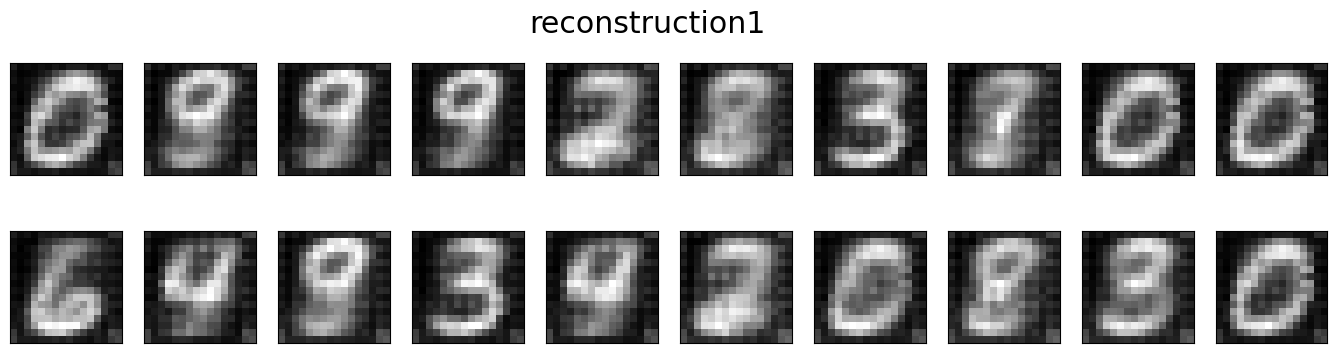

In [29]:
save = False
plot_dir = "emnist/GTs/Class"
from pathlib import Path
import shutil
if save:
    Path(f"plots/{plot_dir}/runfile").mkdir(parents=True, exist_ok=True)
    shutil.copytree(model_src, f"plots/{plot_dir}/runfile", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)
data = save_data(model, Features)

(100,)


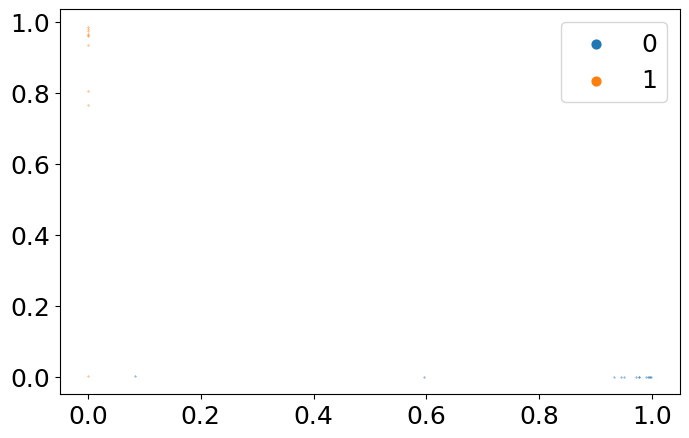

In [30]:
plt.figure(figsize=[8,5])
N = 10000
z_val = data["test_y"][-N:]
z_train = data["train_y"]
center = np.mean(z_train)
std = np.std(z_train)

#z_train = (z_train - center) / std
#z_val = (z_val - center) / std
#z_test = (z_test - center) / std
y = np.argmax(data["test_l"][-N:],axis=1)
z0 = z_val[:,0]
z1 = z_val[:,1]
print(y.shape)
for i in range(2):
    z0i = z0[y==i]
    z1i = z1[y==i]
    plt.scatter(z0i,z1i, s=0.1, label=i)
plt.legend(markerscale=20.)

if save:
    plt.savefig(f"plots/{plot_dir}/0_1.png", bbox_inches='tight')

In [21]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(z_val)
print(embedding.shape)

(100, 2)


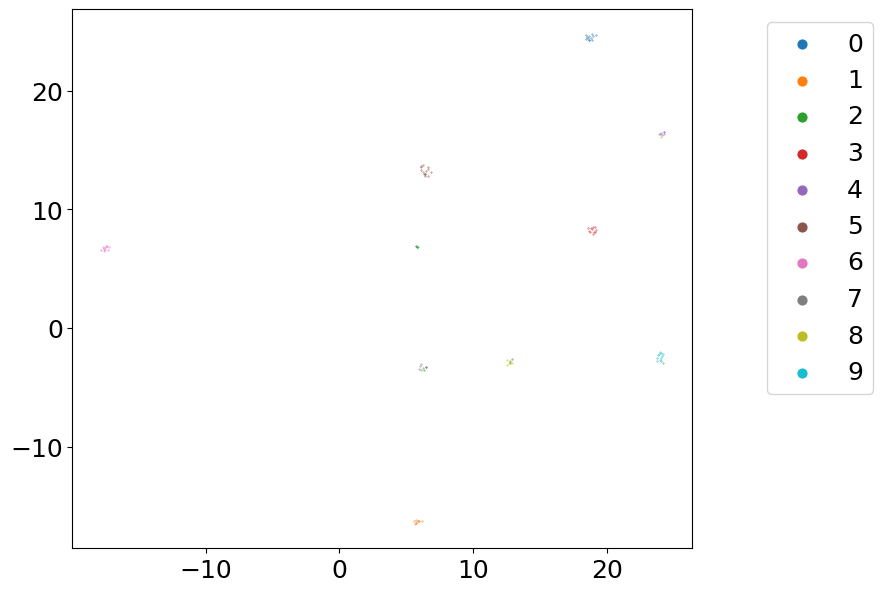

In [22]:
plt.figure(figsize=[8,7])
y = np.argmax(data["test_l"][-N:],axis=1)
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.legend(markerscale=20.,loc='upper left',bbox_to_anchor=(1.1, 1.))
if save:
    plt.savefig(f"plots/GTs/Class/umap.png",bbox_inches='tight')

In [18]:
def save_data(orig_model, feature_model):
    train_data = orig_model.train_data[:100]

    """
    Gen_samples = pd.read_pickle("data/MNIST/mnist16")
    Gen_samples = (Gen_samples - torch.mean(Gen_samples)) / torch.std(Gen_samples)
    #Gen_samples = Gen_samples * torch.std(train_samples) + torch.mean(train_samples)
    Gen_samples = Gen_samples * 0.3081 + 0.1307
    rand_perm = torch.randperm(Gen_samples.shape[0])
    Gen_samples = Gen_samples.reshape(-1,256)
        
    print(train_data[0].shape)
    train_data_img = torch.cat([train_data[0], Gen_samples[rand_perm]], dim=0)
    train_data_labels = torch.cat([train_data[1], torch.zeros([rand_perm.shape[0],10])], dim=0)
    print(train_data_img.shape)
    train_data = (train_data_img, train_data_labels)
    """
    
    val_data = orig_model.val_data[:100]
    test_data = orig_model.test_data[:100]
    
    conditioned = orig_model.apply_conditions(train_data)
    train_samples = conditioned.x0
    c_t_ = conditioned.condition
    c_t = torch.empty((c_t_.shape[0], 0), device=c_t_.device)
    
    conditioned = orig_model.apply_conditions(val_data)
    val_samples = conditioned.x0
    c_v_ = conditioned.condition
    c_v = torch.empty((c_v_.shape[0], 0), device=c_v_.device)

    conditioned = orig_model.apply_conditions(test_data)
    test_samples = conditioned.x0
    c_test_ = conditioned.condition
    c_test = torch.empty((c_test_.shape[0], 0), device=c_test_.device)
    
    device = orig_model.device
    print("encoding traindata...")
    batch_size = orig_model.hparams.batch_size
    z_train = torch.cat([
        feature_model.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        feature_model.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        feature_model.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])
    
    reco = torch.cat([
        orig_model.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_test.split(batch_size), c_test.split(batch_size))
    ])
    z_1 = torch.cat([
        feature_model.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(reco.split(batch_size), c_test.split(batch_size))
    ])
    reco1 = torch.cat([
        orig_model.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_1.split(batch_size), c_test.split(batch_size))
    ])
    orig = test_samples[-100:]
    orig_l = c_test_[-100:]
    orig_l = torch.argmax(orig_l, dim=1)
    reco = reco[-100:]
    reco1 = reco1[-100:]
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(17, 5))
    for i in range(2):
        for j in range(10):
            axes[i][j].imshow(orig[i*10 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].set_title(f"{orig_l[i*10 +j]}")
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Original")
    if save:
        plt.savefig(f"plots/{plot_dir}/original.png", bbox_inches='tight')
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(17, 4))
    for i in range(2):
        for j in range(10):
            axes[i][j].imshow(reco[i*10 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("reconstruction")
    if save:
        plt.savefig(f"plots/{plot_dir}/reconstruction.png", bbox_inches='tight')
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(17, 4))
    for i in range(2):
        for j in range(10):
            axes[i][j].imshow(reco1[i*10 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("reconstruction1")
    if save:
        plt.savefig(f"plots/{plot_dir}/2xreco.png", bbox_inches='tight')

    
    #print(z_train[:10]-train_targets[:10])
    """
    center = torch.mean(z_train)
    std = torch.std(z_train)

    z_train = (z_train - center) / std
    z_val = (z_val - center) / std
    z_test = (z_test - center) / std
    """
    

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    data["train_l"] = c_t_.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()
    data["val_l"] = c_v_.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()
    data["test_l"] = c_test_.cpu().numpy()

    
    path = "data/"
    fileName = path + 'EMnist_Class'
    #fileObject = open(fileName, 'wb')
    
    #pkl.dump(data, fileObject)
    #fileObject.close()
    
    return data

In [19]:
from fff.evaluate.plots import all_conditions
def plot_mnist(rectangular_flow):
    data = {}
    train_batch = rectangular_flow.train_data[:]
    val_batch = rectangular_flow.test_data[:5000]

    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x0
    c_train = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_batch)
    #print(val_batch[1][:10])
    c_val = conditioned.condition
    print(torch.argmax(c_val, dim=1)[:10])
    targets = torch.argmax(c_val, dim=1)
    val_samples = conditioned.x0

    c_val = torch.empty((c_val.shape[0], 0), device=c_val.device)
    
    device = rectangular_flow.device
    
    print("encoding...")
    batch_size = rectangular_flow.hparams.batch_size
    #print(batch_size)
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_val.split(batch_size))
    ])
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(val_samples[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Original")
    """
    classes = np.arange(10)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 8))
    a = np.linspace(-5,5,100)
    for i in range(2):
        for j in range(5):
            axes[i][j].bar(classes, z_val[5*i+j])
    fig.suptitle("Classifier")
    fig.tight_layout()
    """

    accuracy = torch.sum(targets==torch.argmax(z_val,dim=1))/targets.shape[0]
    print(accuracy)
    

In [23]:
path = "data/"
fileName = path + 'Mnist_Class_ext'
fileObject = open(fileName, 'wb')

pkl.dump(data, fileObject)
fileObject.close()

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
encoding...


/export/home/wjoran/miniconda3/envs/py11/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(0.9802)


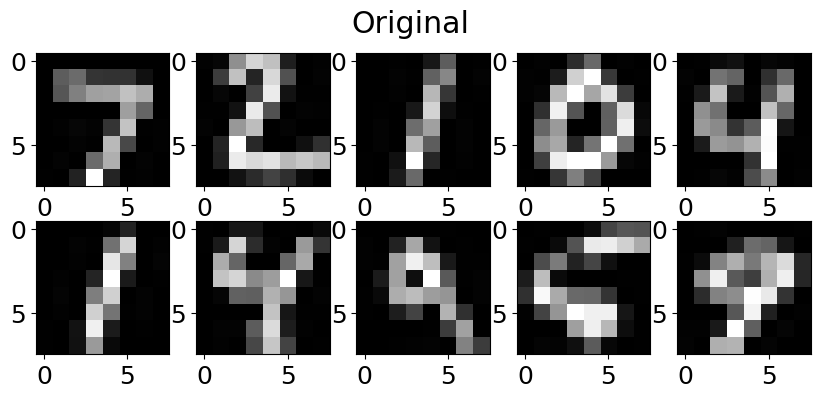

In [20]:
plot_mnist(model)

In [6]:
print(
    list(
    list(
        model.children()
    )[1].children()
    )
)

[ConvolutionalNeuralNetwork(
  (model): Sequential(
    (encoder): Sequential(
      (0): Unflatten(dim=-1, unflattened_size=(1, 16, 16))
      (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): ReLU()
      (7): Flatten(start_dim=-3, end_dim=-1)
      (8): Linear(in_features=1024, out_features=32, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=4096, bias=True)
      (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
      (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (5): Sigmoid()
      (6): Flatten(start_dim=-3, end_dim=-1)
    )
  )
), ResNet(
  (model

In [24]:
print(
    list(
    list(
    list(
    list(
    list(
        model.children()
    )[1].children()
    )[1].children()
    )[0].children()
    )[0].children()
    )[:]
)

[SkipConnection(
  (inner): Sequential(
    (Hidden_Layer_0): Linear(in_features=10, out_features=512, bias=True)
    (Hidden_Activation_0): SiLU()
    (Hidden_Layer_1): Linear(in_features=512, out_features=512, bias=True)
    (Hidden_Activation_1): SiLU()
    (Output_Layer): Linear(in_features=512, out_features=10, bias=True)
  )
), SkipConnection(
  (inner): Sequential(
    (Hidden_Layer_0): Linear(in_features=10, out_features=512, bias=True)
    (Hidden_Activation_0): SiLU()
    (Hidden_Layer_1): Linear(in_features=512, out_features=512, bias=True)
    (Hidden_Activation_1): SiLU()
    (Output_Layer): Linear(in_features=512, out_features=10, bias=True)
  )
), Softmax(dim=None)]
